# Bootstrap models

- Create sample of estimates with selection based on the probality of error

In [12]:
library(haven)
library(sdazar)
library(brms)
# options(mc.cores = parallel::detectCores()-2)

In [13]:
library(doParallel)

In [14]:
# create sample of estimates (10 for testing)

seed = 102330
df = data.table(read_dta('../data/FOR_BOOTSTRAP_FINAL_NOV_19_2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

In [15]:
# head(df)

In [16]:
df = melt(df, id_vars=c('ctry', 'year'), measure = patterns("^Ex", "^pr"), value.name = c("le", "pr"))
df = df[!is.na(le)]

setorder(df, ctry, year)

df[, spr := pr / sum(pr), by=.(ctry, year)]
df = df[year>=1900]

df[, N := .N, by=.(ctry,year)]

set.seed = seed
samples = df[,.SD[ sample(.N, 100, replace=TRUE, prob=pr)], by = .(ctry,year)]

samples[, sample_index := 1:.N, by=.(ctry, year)]

In [17]:
# merge covariates

covs = fread('../data//featured_LE_data.csv')

In [18]:
covs[, c("Ex", "y", "wy", "max_le") := NULL]

In [19]:
samples = merge(samples, covs, on=c('ctry','year'))

In [30]:
fwrite(samples, '../data/bs_samples.csv', row.names=FALSE)

In [21]:
print(names(samples))

 [1] "ctry"         "year"         "variable"     "le"           "pr"          
 [6] "spr"          "N"            "sample_index" "gdp_pc"       "urban"       
[11] "lit"          "water"        "sewage"       "elec"         "us_aid"      
[16] "tfr"          "gyear"        "ctry_year"    "igdp_pc"      "iurban"      
[21] "ilit"         "itfr"         "iwater"       "isewage"      "ielec"       
[26] "igdp_log"     "iurban_log"   "ilit_log"     "iwater_log"   "isewage_log" 
[31] "ielec_log"    "zyear"       


In [ ]:
# run models in parallel

library(doParallel)
library(data.table)

cl = makeCluster(15)
registerDoParallel(cl)
seed = 103231

df = fread('/home/s/sdaza/00projects/lambda/data/bs_samples.csv')

results = foreach(i=1:100, .combine=cbind) %dopar% {

    library(data.table)
    library(brms)
    library(loo)

    prior = set_prior("normal(0, 5)", class = "b")

    test = copy(df[sample_index==i])
    test[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
    test[, wy := log(-log(1-y))]
    test[, max_le := max(le+1.05), by = ctry] # to recover values later

    m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year),
           data = test,
           iter = 2000,
           chains = 2,
           seed = seed,
           prior=prior,
           cores=1)

    m1.2 = brm(formula = wy ~ 1 + igdp_log  + iurban_log +  (igdp_log|ctry_year),
          data = test,
          iter = 2000,
          chains = 2,
          seed = seed,
          prior = prior,
          cores=1)

    m1.3 = brm(formula = wy ~ 1 + igdp_log  + ilit_log +  (igdp_log|ctry_year),
          data = test,
          iter = 2000,
          chains = 2,
          seed = seed,
          prior = prior,
          cores=1)

    m1.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year),
          data = test,
          iter = 2000,
          chains = 2,
          seed = seed,
          prior = prior,
          control=  list(adapt_delta=0.90),
          cores=1)

    loo1.1 = loo(m1.1, reloo=TRUE)
    loo1.2 = loo(m1.2, reloo=TRUE)
    loo1.3 = loo(m1.3, reloo=TRUE)
    loo1.4 = loo(m1.4, reloo=TRUE)

    loo_list_noyear = list(loo1.1, loo1.2, loo1.3, loo1.4)

    loo_model_weights(loo_list_noyear)

}

saveRDS(t(results), "/home/s/sdaza/00projects/lambda/output/weights.rds")


# Explore distribution of stacking model weight

- Using models summarized in the file description, shift_1900_stacking.csv
- Variability of weights is rather small

In [55]:
w = data.table(readRDS('output/weights.rds'))

In [56]:
options(repr.plot.width=6, repr.plot.height=4)

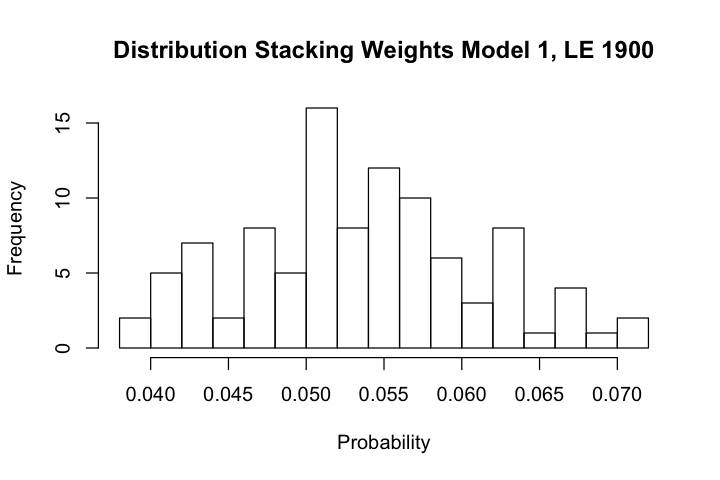

In [57]:
hist(w$model1, main='Distribution Stacking Weights Model 1, LE 1900', 
     xlab='Probability', breaks = 20)

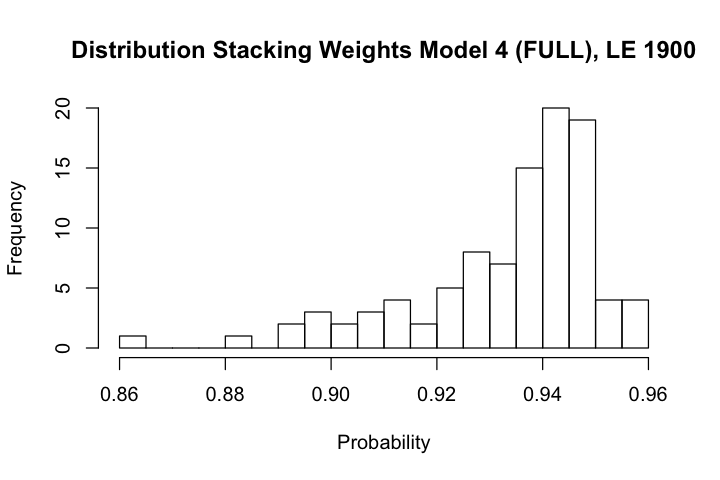

In [58]:
hist(w$model4, main='Distribution Stacking Weights Model 4 (FULL), LE 1900', 
     xlab='Probability', breaks = 30)

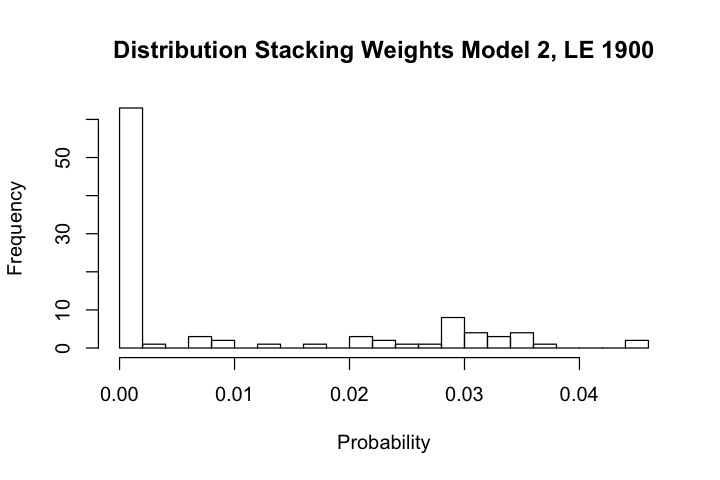

In [59]:
hist(w$model2, main='Distribution Stacking Weights Model 2, LE 1900', 
     xlab='Probability', breaks = 20)

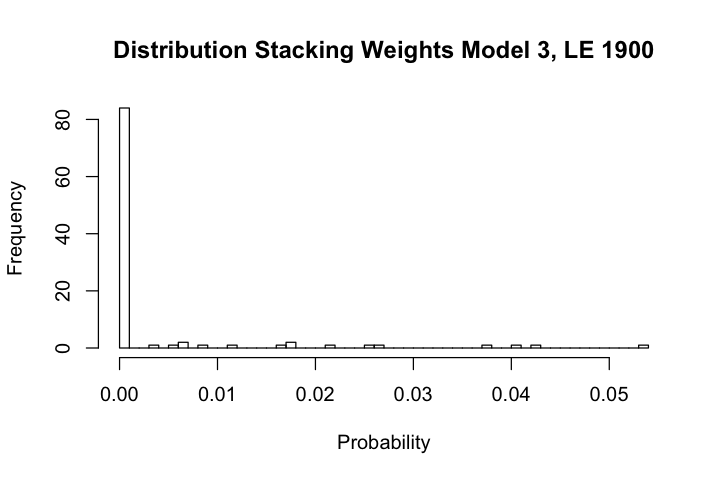

In [60]:
hist(w$model3, main='Distribution Stacking Weights Model 3, LE 1900', 
     xlab='Probability', breaks = 50)